In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heads-or-tails-image-classification/sample_submission.csv
/kaggle/input/heads-or-tails-image-classification/test/unknown_024.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_116.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_003.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_017.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_067.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_037.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_148.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_094.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_179.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_002.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_004.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_006.jpg
/kaggle/input/heads-or-tails-image-classification/test/unknown_144.jpg
/kagg

# Importing Libraries

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models

E0000 00:00:1749377711.915226      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749377711.997093      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load and Explore DATA

Load labels

In [3]:
import os
import pandas as pd

# Define train path
train_dir = "/kaggle/input/heads-or-tails-image-classification/train"

# Create list of image paths and labels
data = []
for label in ['heads', 'tails']:
    label_dir = os.path.join(train_dir, label)
    for fname in os.listdir(label_dir):
        if fname.endswith('.jpg') or fname.endswith('.png'):
            path = os.path.join(label_dir, fname)
            data.append((path, label))

# Create DataFrame
df = pd.DataFrame(data, columns=["filepath", "label"])
print(f"Total training images: {len(df)}")
df.head()


Total training images: 800


,filepath,label
0,/kaggle/input/heads-or-tails-image-classificat...,heads
1,/kaggle/input/heads-or-tails-image-classificat...,heads
2,/kaggle/input/heads-or-tails-image-classificat...,heads
3,/kaggle/input/heads-or-tails-image-classificat...,heads
4,/kaggle/input/heads-or-tails-image-classificat...,heads


# Vaildation split and Visualization

In [4]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

Split into train and validation sets

In [5]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

Check class balance

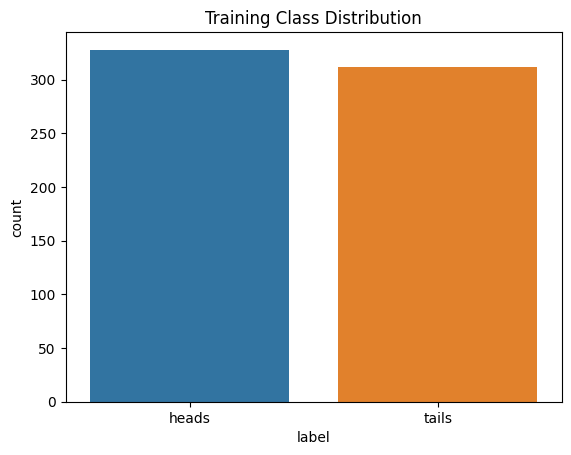

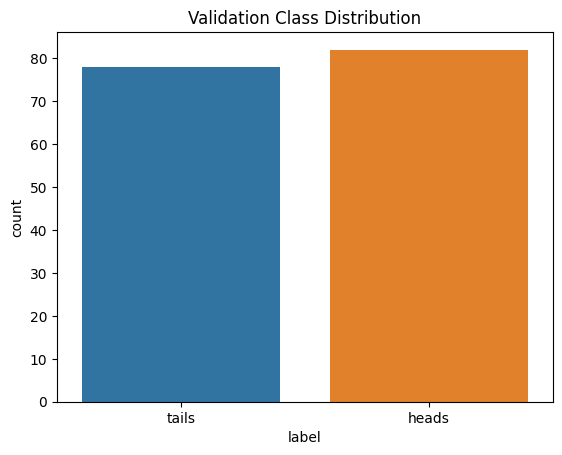

In [6]:
sns.countplot(data=train_df, x='label')
plt.title('Training Class Distribution')
plt.show()

sns.countplot(data=val_df, x='label')
plt.title('Validation Class Distribution')
plt.show()

# Image Preprocessing with ImageDataGenerator

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

Data generators

In [8]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_gen = ImageDataGenerator(rescale=1./255)

Flow from Data Frame

In [9]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 640 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.


# CNN Model (Lightweight + Accurate)

In [10]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training the MODEL

In [11]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 839ms/step - accuracy: 0.5254 - loss: 0.7759 - val_accuracy: 0.5312 - val_loss: 0.6737
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 722ms/step - accuracy: 0.6108 - loss: 0.6579 - val_accuracy: 0.6812 - val_loss: 0.5784
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 647ms/step - accuracy: 0.6938 - loss: 0.6040 - val_accuracy: 0.7437 - val_loss: 0.5470
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 684ms/step - accuracy: 0.7360 - loss: 0.5605 - val_accuracy: 0.6250 - val_loss: 0.6707
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 653ms/step - accuracy: 0.6796 - loss: 0.5884 - val_accuracy: 0.7000 - val_loss: 0.6022
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 679ms/step - accuracy: 0.7355 - loss: 0.5759 - val_accuracy: 0.7563 - val_loss: 0.5105
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 658ms/step - accuracy: 0.7337 - loss: 0.5390 - val_accuracy: 0.6000 - val_loss: 0.6513
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 759ms/step - accuracy: 0.6823 - loss: 0.6402 - val_accu

# Accuracy and loss plot

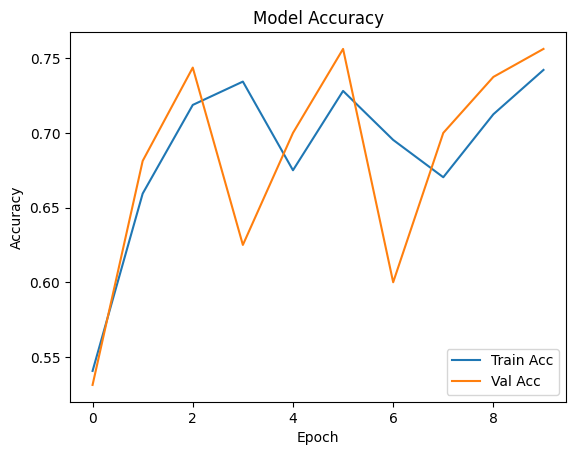

In [12]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# Prepare submission

Load test image paths

In [13]:
test_dir = "/kaggle/input/heads-or-tails-image-classification/test"
test_files = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]

Create DataFrame

In [14]:
test_df = pd.DataFrame(test_files, columns=["filepath"])


Test generator

In [15]:
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col=None,
    class_mode=None,
    target_size=IMG_SIZE,
    batch_size=1,
    shuffle=False
)

Found 200 validated image filenames.


Predictions

In [16]:
preds = model.predict(test_data)
labels = ['heads' if p < 0.5 else 'tails' for p in preds]

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


Assigning the predictions

In [17]:
import pandas as pd

# Load the sample submission file
submission_df = pd.read_csv('/kaggle/input/heads-or-tails-image-classification/sample_submission.csv')

# Now this line will work
submission_df.loc[:, 'probability_of_heads'] = preds.flatten()

# Save the final submission file
submission_df.to_csv('submission.csv', index=False)


Checking if the the final sub has only two columns

In [18]:
submission_df.head()

,prediction_id,probability_of_heads
0,1,0.088852
1,2,0.531576
2,3,0.160434
3,4,0.099639
4,5,0.075511


The submission file matches with the sample file.